# **Causal De-biasing Fusion Pipeline**

In [1]:
!pip install monai torchinfo pytorch-metric-learning

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.3/1.3 MB 23.7 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 115.3/115.3 kB 8.5 MB/s eta 0:00:00


In [2]:
import os
import cv2
import pandas as pd
import numpy as np
from numpy.linalg import norm
from sklearn.preprocessing import LabelEncoder
from sklearn.metrics import accuracy_score, f1_score, precision_score, recall_score, roc_auc_score, confusion_matrix
import matplotlib.pyplot as plt
import copy

import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from torchvision.io import read_image
import torchvision.transforms.v2 as transforms
from torchvision.transforms import Compose
from torch.utils.data import Dataset, DataLoader
from torchvision.models import resnet50, ResNet50_Weights
from pytorch_metric_learning import losses

import nltk
from nltk import word_tokenize
from gensim import models

from transformers import AutoTokenizer, DistilBertModel

import monai.transforms as mt

from torchinfo import summary

from tqdm.notebook import tqdm

from google.colab import drive
drive.mount('/content/drive')

SEED = 42
np.random.seed(SEED)
torch.manual_seed(SEED)
torch.cuda.manual_seed(SEED)
torch.backends.cudnn.deterministic = True
nltk.download('punkt')
device = "cuda" if torch.cuda.is_available() else "cpu"

Mounted at /content/drive


[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Unzipping tokenizers/punkt.zip.


## **Data Setup**

Load evaluation set

In [3]:
df = pd.read_csv('/content/drive/MyDrive/EvaluationSet/test.csv')

In [4]:
df.shape

(2085, 14)

In [5]:
df['img_path'].unique()

array(['/content/drive/My Drive/CVFinalProject/p10000980/s50985099/6ad03ed1-97ee17ee-9cf8b320-f7011003-cd93b42d.jpg',
       '/content/drive/My Drive/CVFinalProject/p10000980/s57861150/5aa15ba6-55f5e96e-39cea686-7c3b28b2-b8c97a88.jpg',
       '/content/drive/My Drive/CVFinalProject/p10000980/s58206436/54affd39-8bf24209-232bac8a-df6c277a-398ee8a5.jpg',
       ...,
       '/content/drive/My Drive/CVFinalProject/p10996711/s53713923/2bd0c353-5bb42c81-f0a04190-a3ae5397-5c239238.jpg',
       '/content/drive/My Drive/CVFinalProject/p10996711/s55777492/03619e1b-f4c5034d-0185d3dd-1802051f-3a0242f4.jpg',
       '/content/drive/My Drive/CVFinalProject/p10997073/s56638000/e27d238a-8f67f3c5-866d2fa5-fd86371d-520aded6.jpg'],
      dtype=object)

In [6]:
df['reports'] = df['reports'].str.lower().str.replace("\n", " ").str.strip()
df['img_path'] = df['img_path'].str.replace('/content/drive/My Drive/CVFinalProject/[a-z0-9]+/[a-z0-9]+', '/content/drive/MyDrive/EvaluationSet', regex = True)
df.head()

,dicom_id,subject_id,study_id,ViewPosition,Rows,Columns,label,img_path,reports,gender,anchor_age,marital_status,race,general_race_group
0,6ad03ed1-97ee17ee-9cf8b320-f7011003-cd93b42d,10000980,50985099,PA,2022,1870,0,/content/drive/MyDrive/EvaluationSet/6ad03ed1-...,final report examination: chest (pa and lat)...,F,73,MARRIED,BLACK/AFRICAN AMERICAN,Black/African Descent
1,5aa15ba6-55f5e96e-39cea686-7c3b28b2-b8c97a88,10000980,57861150,PA,3056,2544,1,/content/drive/MyDrive/EvaluationSet/5aa15ba6-...,final report examination: chest (pa and lat)...,F,73,MARRIED,BLACK/AFRICAN AMERICAN,Black/African Descent
2,54affd39-8bf24209-232bac8a-df6c277a-398ee8a5,10000980,58206436,AP,3056,2544,1,/content/drive/MyDrive/EvaluationSet/54affd39-...,wet read: ___ ___ ___ 6:47 am 1. new mild pu...,F,73,MARRIED,BLACK/AFRICAN AMERICAN,Black/African Descent
3,c7526473-7b7214ee-a5d58d12-29d1f67f-9f4edf00,10000980,58636672,PA,2022,2022,1,/content/drive/MyDrive/EvaluationSet/c7526473-...,final report examination: chest (pa and lat)...,F,73,MARRIED,BLACK/AFRICAN AMERICAN,Black/African Descent
4,925b9496-a956d7b2-05185e52-bb33313b-c06ee522,10000980,59988438,PA,3056,2544,1,/content/drive/MyDrive/EvaluationSet/925b9496-...,final report indication: shortness of breath...,F,73,MARRIED,BLACK/AFRICAN AMERICAN,Black/African Descent


In [7]:
df['img_path'].unique()

array(['/content/drive/MyDrive/EvaluationSet/6ad03ed1-97ee17ee-9cf8b320-f7011003-cd93b42d.jpg',
       '/content/drive/MyDrive/EvaluationSet/5aa15ba6-55f5e96e-39cea686-7c3b28b2-b8c97a88.jpg',
       '/content/drive/MyDrive/EvaluationSet/54affd39-8bf24209-232bac8a-df6c277a-398ee8a5.jpg',
       ...,
       '/content/drive/MyDrive/EvaluationSet/2bd0c353-5bb42c81-f0a04190-a3ae5397-5c239238.jpg',
       '/content/drive/MyDrive/EvaluationSet/03619e1b-f4c5034d-0185d3dd-1802051f-3a0242f4.jpg',
       '/content/drive/MyDrive/EvaluationSet/e27d238a-8f67f3c5-866d2fa5-fd86371d-520aded6.jpg'],
      dtype=object)

In [8]:
IMG_CLASSES = ['Normal','PleuralEffusion']
NUM_CLASSES = len(IMG_CLASSES)
IMG_SIZE = 224
class MultiModalDataset(Dataset):
    def __init__(self, indices, image_dir, texts, labels, transform = None):
        # load dataset
        self.images = []
        for image_file in tqdm(image_dir, position = 0, leave = True):
            image = transforms.Resize([IMG_SIZE, IMG_SIZE])(read_image(image_file))
            self.images.append(image)


        self.indices = indices
        self.texts = texts
        self.labels = labels

        # transforms
        self.transform = transform

    def __len__(self):
        return len(self.images)

    def __getitem__(self, idx):
        image = self.transform(self.images[idx]) if self.transform is not None else self.images[idx]
        image = image.repeat(3, 1, 1)
        # image = (image - image.min())/(image.max() - image.min()) # map to [0, 1]
        index = self.indices[idx]
        label = self.labels[idx]
        text = self.texts[idx]
        sample = {'index': index, 'image': image, 'text': text, 'label': label}#transforms.ToDtype(torch.uint8, scale=True)(mask)}
        return sample

In [9]:
val_transforms = transforms.Compose([
    mt.NormalizeIntensity(),
])

val_ds = MultiModalDataset(list(df.index),
                           df['img_path'].values,
                           df['reports'].values,
                           df['label'].values,
                           transform = val_transforms)

  0%|          | 0/2085 [00:00<?, ?it/s]

/usr/local/lib/python3.10/dist-packages/torchvision/transforms/functional.py:1603: UserWarning: The default value of the antialias parameter of all the resizing transforms (Resize(), RandomResizedCrop(), etc.) will change from None to True in v0.17, in order to be consistent across the PIL and Tensor backends. To suppress this warning, directly pass antialias=True (recommended, future default), antialias=None (current default, which means False for Tensors and True for PIL), or antialias=False (only works on Tensors - PIL will still use antialiasing). This also applies if you are using the inference transforms from the models weights: update the call to weights.transforms(antialias=True).
  warnings.warn(


In [14]:
BATCH_SIZE = 6
val_kwargs = {'batch_size': BATCH_SIZE, 'shuffle': False}
val_loader = DataLoader(val_ds, **val_kwargs)

In [15]:
for batch in val_loader:
    print(batch['index'].shape)
    print(batch['image'].shape)
    print(len(batch['text'])) # will tokenize in training loop...
    print(batch['label'].shape)
    break

torch.Size([6])
torch.Size([6, 3, 224, 224])
6
torch.Size([6])


## **Model**

In [63]:
bert = DistilBertModel.from_pretrained("distilbert-base-uncased")
tokenizer = AutoTokenizer.from_pretrained("distilbert-base-uncased")

In [64]:
resnet = torch.nn.Sequential(*list(resnet50(weights=ResNet50_Weights.DEFAULT).children())[:-1])

In [65]:
class MultiModalModel(nn.Module):
    """
    Model that outputs representations for image and text
    """
    def __init__(self, cv_encoder, nlp_encoder, tokenizer):
        super(MultiModalModel, self).__init__()
        self.tokenizer = tokenizer
        self.nlp_encoder = nlp_encoder
        self.nlp_out = nn.Linear(768, 256) # bert
        self.cv_encoder = cv_encoder
        self.cv_out = nn.Linear(2048, 256) # resnet

    def forward(self, im, text):
        tokens = self.tokenizer(text, return_tensors="pt", padding='max_length', truncation=True).to(device)
        z_text = self.nlp_encoder(**tokens).last_hidden_state
        z_text = self.nlp_out(z_text).mean(axis = 1) # average sequence representation
        z_im = self.cv_encoder(im).squeeze()
        z_im = self.cv_out(z_im)
        return z_im, z_text

In [66]:
class FusionModel(nn.Module):
    """
    Model that performs intermediate fusion and outputs logits
    """
    def __init__(self, cv_encoder, nlp_encoder, tokenizer):
        super(FusionModel, self).__init__()
        multimodal_encoder = MultiModalModel(cv_encoder, nlp_encoder, tokenizer)
        self.multimodal_endover = multimodal_encoder
        self.out = nn.Linear(512, 2)

    def forward(self, im, text):
        z_im, z_text = self.multimodal_endover(im, text)
        z = torch.cat([z_im, z_text], axis = 1)
        z = self.out(z)
        return z

## **Evaluation**

Define some functions

In [67]:
def get_preds(model, test_loader):
    """
    Get predictions
    """
    indices = []
    preds = []
    labels = []
    with torch.no_grad():
        for batch in tqdm(test_loader, position = 0, leave = True):
            logits = model(batch['image'].to(device), batch['text'])
            preds.append(torch.argmax(logits, dim = 1).cpu().numpy())
            labels.append(batch['label'].numpy())
            indices.append(batch['index'].numpy())

    indices = np.concatenate(indices)
    preds = np.concatenate(preds)
    labels = np.concatenate(labels)

    return indices, preds, labels

def get_metrics(preds, labels):
    """
    Get metrics
    """

    accuracy = accuracy_score(labels, preds)
    precision = precision_score(labels, preds)
    recall = recall_score(labels, preds)
    f1 = f1_score(labels, preds)
    aucroc = roc_auc_score(labels, preds)
    confm = confusion_matrix(labels, preds, normalize="true")

    print(f"Accuracy: {accuracy}")
    print(f"Precision: {precision}")
    print(f"Recall: {recall}")
    print(f"F1: {f1}")
    print(f"AUC-ROC: {aucroc}")
    print(f"Confusion Matrix: {confm}")

    return accuracy, precision, recall, f1, aucroc, confm

Evaluation options with or without matching

Load Models

In [68]:
# sample_sizes = [1000, 2000, 3000, 4000, 5000]
sample_sizes = [5000]
models_ndb = []
models_db = []
for N in sample_sizes:
  load_ndb = FusionModel(resnet, bert, tokenizer).to(device)
  load_ndb.load_state_dict(torch.load(f"/content/drive/MyDrive/weights/fusion_n{N}.pt"))
  load_db = FusionModel(resnet, bert, tokenizer).to(device)
  load_db.load_state_dict(torch.load(f"/content/drive/MyDrive/weights/debiased_fusion_n{N}.pt"))
  models_ndb += [load_ndb]
  models_db += [load_db]

Evaluation

In [69]:
# not debiased
res_ndb = pd.DataFrame()
for idx, model_ndb in enumerate(models_ndb):
  test_indices, test_preds, test_labels = get_preds(model_ndb, val_loader)
  print(sum(test_indices == df.index.values)) # making sure order is same
  df['pred'] = test_preds # assigning predicted labels
  print(f"########### {sample_sizes[idx]} ###########")
  for group in np.unique(df.general_race_group.values):
    print(f"########### {group} ###########")
    accuracy, precision, recall, f1, aucroc, confm = get_metrics(df[df['general_race_group'] == group]['pred'].values, df[df['general_race_group'] == group]['label'].values)
    res = pd.DataFrame({'accuracy': [accuracy],
                        'precision': [precision],
                        'recall': [recall],
                        'f1': [f1],
                        'auc': [aucroc],
                        'group': [group],
                        'sample_size': [sample_sizes[idx]],
                        'debiased': [False]})
    res_ndb = pd.concat([res_ndb, res], axis = 0)

  0%|          | 0/348 [00:00<?, ?it/s]

2085
########### 5000 ###########
########### Asian ###########
Accuracy: 0.972972972972973
Precision: 0.98
Recall: 0.98
F1: 0.98
AUC-ROC: 0.9691666666666666
Confusion Matrix: [[0.95833333 0.04166667]
 [0.02       0.98      ]]
########### Black/African Descent ###########
Accuracy: 0.944206008583691
Precision: 0.9370629370629371
Recall: 0.9710144927536232
F1: 0.9537366548042706
AUC-ROC: 0.9381388253241799
Confusion Matrix: [[0.90526316 0.09473684]
 [0.02898551 0.97101449]]
########### Hispanic/Latino ###########
Accuracy: 0.9782608695652174
Precision: 0.9629629629629629
Recall: 1.0
F1: 0.9811320754716981
AUC-ROC: 0.975
Confusion Matrix: [[0.95 0.05]
 [0.   1.  ]]
########### Other Races ###########
Accuracy: 0.9655172413793104
Precision: 0.9647058823529412
Recall: 0.9879518072289156
F1: 0.9761904761904762
AUC-ROC: 0.9485213581599123
Confusion Matrix: [[0.90909091 0.09090909]
 [0.01204819 0.98795181]]
########### White/Caucasian ###########
Accuracy: 0.967515923566879
Precision: 0.97447

In [70]:
# debiased
res_db = pd.DataFrame()
for idx, model_db in enumerate(models_db):
  test_indices, test_preds, test_labels = get_preds(model_db, val_loader)
  print(sum(test_indices == df.index.values)) # making sure order is same
  df['db_pred'] = test_preds # assigning predicted labels
  print(f"########### {sample_sizes[idx]} ###########")
  for group in np.unique(df.general_race_group.values):
    print(f"########### {group} ###########")
    accuracy, precision, recall, f1, aucroc, confm = get_metrics(df[df['general_race_group'] == group]['db_pred'].values, df[df['general_race_group'] == group]['label'].values)
    res = pd.DataFrame({'accuracy': [accuracy],
                        'precision': [precision],
                        'recall': [recall],
                        'f1': [f1],
                        'auc': [aucroc],
                        'group': [group],
                        'sample_size': [sample_sizes[idx]],
                        'debiased': [True]})
    res_db = pd.concat([res_db, res], axis = 0)

  0%|          | 0/348 [00:00<?, ?it/s]

2085
########### 5000 ###########
########### Asian ###########
Accuracy: 1.0
Precision: 1.0
Recall: 1.0
F1: 1.0
AUC-ROC: 1.0
Confusion Matrix: [[1. 0.]
 [0. 1.]]
########### Black/African Descent ###########
Accuracy: 0.9742489270386266
Precision: 0.9714285714285714
Recall: 0.9855072463768116
F1: 0.9784172661870504
AUC-ROC: 0.9717009916094583
Confusion Matrix: [[0.95789474 0.04210526]
 [0.01449275 0.98550725]]
########### Hispanic/Latino ###########
Accuracy: 0.9891304347826086
Precision: 0.9811320754716981
Recall: 1.0
F1: 0.9904761904761905
AUC-ROC: 0.9874999999999999
Confusion Matrix: [[0.975 0.025]
 [0.    1.   ]]
########### Other Races ###########
Accuracy: 1.0
Precision: 1.0
Recall: 1.0
F1: 1.0
AUC-ROC: 1.0
Confusion Matrix: [[1. 0.]
 [0. 1.]]
########### White/Caucasian ###########
Accuracy: 0.9859872611464968
Precision: 0.9863636363636363
Recall: 0.9935897435897436
F1: 0.989963503649635
AUC-ROC: 0.9811044952258342
Confusion Matrix: [[0.96861925 0.03138075]
 [0.00641026 0.99358

Combine debiased and not debiased results

In [71]:
res_df = pd.concat([res_ndb, res_db], axis = 0)
res_df.to_csv('debias_evaluation_{}.csv'.format(sample_sizes[0]), index = False)

In [72]:
res_df

,accuracy,precision,recall,f1,auc,group,sample_size,debiased
0,0.972973,0.980000,0.980000,0.980000,0.969167,Asian,5000,False
0,0.944206,0.937063,0.971014,0.953737,0.938139,Black/African Descent,5000,False
0,0.978261,0.962963,1.000000,0.981132,0.975000,Hispanic/Latino,5000,False
0,0.965517,0.964706,0.987952,0.976190,0.948521,Other Races,5000,False
0,0.967516,0.974476,0.978938,0.976702,0.960180,White/Caucasian,5000,False
0,1.000000,1.000000,1.000000,1.000000,1.000000,Asian,5000,True
0,0.974249,0.971429,0.985507,0.978417,0.971701,Black/African Descent,5000,True
0,0.989130,0.981132,1.000000,0.990476,0.987500,Hispanic/Latino,5000,True
0,1.000000,1.000000,1.000000,1.000000,1.000000,Other Races,5000,True
0,0.985987,0.986364,0.993590,0.989964,0.981104,White/Caucasian,5000,True


In [62]:
del res_df
del res_ndb
del res_db
del resnet
del bert
del tokenizer
del FusionModel

Combine all results

In [98]:
res_1000 = pd.read_csv('debias_evaluation_1000.csv')
res_2000 = pd.read_csv('debias_evaluation_2000.csv')
res_3000 = pd.read_csv('debias_evaluation_3000.csv')
res_4000 = pd.read_csv('debias_evaluation_4000.csv')
res_5000 = pd.read_csv('debias_evaluation_5000.csv')
res_all = pd.concat([res_1000, res_2000, res_3000, res_4000, res_5000], axis = 0)
res_all = res_all.groupby(['sample_size', 'group']).apply(lambda x: x.sort_values(['debiased'], ascending=False)).reset_index(drop = True)

results for N = 1000

In [99]:
res_all[res_all['sample_size'] == 1000]

,accuracy,precision,recall,f1,auc,group,sample_size,debiased
0,0.932432,0.959184,0.940000,0.949495,0.928333,Asian,1000,True
1,0.959459,1.000000,0.940000,0.969072,0.970000,Asian,1000,False
2,0.957082,0.950704,0.978261,0.964286,0.952288,Black/African Descent,1000,True
3,0.957082,0.950704,0.978261,0.964286,0.952288,Black/African Descent,1000,False
4,0.978261,0.980769,0.980769,0.980769,0.977885,Hispanic/Latino,1000,True
5,0.978261,0.980769,0.980769,0.980769,0.977885,Hispanic/Latino,1000,False
6,1.000000,1.000000,1.000000,1.000000,1.000000,Other Races,1000,True
7,0.991379,1.000000,0.987952,0.993939,0.993976,Other Races,1000,False
8,0.966879,0.971014,0.981685,0.976321,0.957370,White/Caucasian,1000,True
9,0.971338,0.977211,0.981685,0.979443,0.964692,White/Caucasian,1000,False


results for N = 2000

In [100]:
res_all[res_all['sample_size'] == 2000]

,accuracy,precision,recall,f1,auc,group,sample_size,debiased
10,1.000000,1.000000,1.000000,1.000000,1.000000,Asian,2000,True
11,0.986486,1.000000,0.980000,0.989899,0.990000,Asian,2000,False
12,0.965665,0.957746,0.985507,0.971429,0.961175,Black/African Descent,2000,True
13,0.965665,0.971014,0.971014,0.971014,0.964455,Black/African Descent,2000,False
14,0.989130,0.981132,1.000000,0.990476,0.987500,Hispanic/Latino,2000,True
15,0.967391,0.980392,0.961538,0.970874,0.968269,Hispanic/Latino,2000,False
16,1.000000,1.000000,1.000000,1.000000,1.000000,Other Races,2000,True
17,0.991379,1.000000,0.987952,0.993939,0.993976,Other Races,2000,False
18,0.976433,0.974797,0.991758,0.983205,0.966590,White/Caucasian,2000,True
19,0.964968,0.983225,0.966117,0.974596,0.964230,White/Caucasian,2000,False


results for N = 3000

In [101]:
res_all[res_all['sample_size'] == 3000]

,accuracy,precision,recall,f1,auc,group,sample_size,debiased
20,0.986486,1.000000,0.980000,0.989899,0.990000,Asian,3000,True
21,0.959459,0.979592,0.960000,0.969697,0.959167,Asian,3000,False
22,0.974249,0.971429,0.985507,0.978417,0.971701,Black/African Descent,3000,True
23,0.969957,0.964539,0.985507,0.974910,0.966438,Black/African Descent,3000,False
24,0.989130,0.981132,1.000000,0.990476,0.987500,Hispanic/Latino,3000,True
25,0.989130,0.981132,1.000000,0.990476,0.987500,Hispanic/Latino,3000,False
26,1.000000,1.000000,1.000000,1.000000,1.000000,Other Races,3000,True
27,1.000000,1.000000,1.000000,1.000000,1.000000,Other Races,3000,False
28,0.981529,0.978398,0.995421,0.986836,0.972606,White/Caucasian,3000,True
29,0.979618,0.980072,0.990842,0.985428,0.972409,White/Caucasian,3000,False


results for N = 4000

In [102]:
res_all[res_all['sample_size'] == 4000]

,accuracy,precision,recall,f1,auc,group,sample_size,debiased
30,1.000000,1.000000,1.000000,1.000000,1.000000,Asian,4000,True
31,0.959459,1.000000,0.940000,0.969072,0.970000,Asian,4000,False
32,0.974249,0.978261,0.978261,0.978261,0.973341,Black/African Descent,4000,True
33,0.969957,0.978102,0.971014,0.974545,0.969718,Black/African Descent,4000,False
34,0.978261,0.980769,0.980769,0.980769,0.977885,Hispanic/Latino,4000,True
35,0.978261,0.980769,0.980769,0.980769,0.977885,Hispanic/Latino,4000,False
36,1.000000,1.000000,1.000000,1.000000,1.000000,Other Races,4000,True
37,1.000000,1.000000,1.000000,1.000000,1.000000,Other Races,4000,False
38,0.984076,0.984559,0.992674,0.988600,0.978555,White/Caucasian,4000,True
39,0.980255,0.988940,0.982601,0.985760,0.978748,White/Caucasian,4000,False


results for N = 5000

In [103]:
res_all[res_all['sample_size'] == 5000]

,accuracy,precision,recall,f1,auc,group,sample_size,debiased
40,1.000000,1.000000,1.000000,1.000000,1.000000,Asian,5000,True
41,0.972973,0.980000,0.980000,0.980000,0.969167,Asian,5000,False
42,0.974249,0.971429,0.985507,0.978417,0.971701,Black/African Descent,5000,True
43,0.944206,0.937063,0.971014,0.953737,0.938139,Black/African Descent,5000,False
44,0.989130,0.981132,1.000000,0.990476,0.987500,Hispanic/Latino,5000,True
45,0.978261,0.962963,1.000000,0.981132,0.975000,Hispanic/Latino,5000,False
46,1.000000,1.000000,1.000000,1.000000,1.000000,Other Races,5000,True
47,0.965517,0.964706,0.987952,0.976190,0.948521,Other Races,5000,False
48,0.985987,0.986364,0.993590,0.989964,0.981104,White/Caucasian,5000,True
49,0.967516,0.974476,0.978938,0.976702,0.960180,White/Caucasian,5000,False


save results

In [104]:
res_all.to_csv('debias_evaluation_all.csv', index = False)

Visualization

<Figure size 640x480 with 0 Axes>

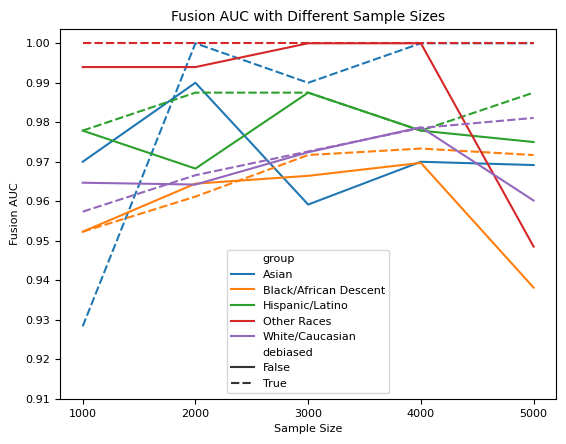

In [94]:
import seaborn as sns
import matplotlib.pyplot as plt
plt.figure()
fig, ax = plt.subplots(nrows = 1, ncols = 1)
sns.lineplot(data = res_all, x = 'sample_size', y = 'auc', hue = 'group', style = 'debiased')
ax.set_title('Fusion AUC with Different Sample Sizes', fontsize=10)
ax.set_xlabel('Sample Size', fontsize=8)
ax.set_ylabel('Fusion AUC', fontsize=8)
ax.set_xticks([1000, 2000, 3000, 4000, 5000])
ax.set_yticks(np.linspace(0.91, 1.0, 10))
ax.tick_params(labelsize=8)
ax.legend(fontsize = 8)
# plt.show()
plt.savefig('fusion_auc.png')

calculate SD of AUCs

In [107]:
res_sd = res_all.groupby(['group', 'debiased']).agg(auc_sd = ('auc', 'std'))
res_sd.to_csv('auc_std_by_group.csv')
res_sd

auc_sd
group                 debiased          
Asian                 False     0.011227
                      True      0.031234
Black/African Descent False     0.013010
                      True      0.009085
Hispanic/Latino       False     0.006920
                      True      0.005267
Other Races           False     0.021883
                      True      0.000000
White/Caucasian       False     0.007437
                      True      0.009574

In [108]:
res_all = pd.read_csv('debias_evaluation_all.csv')
res_all

,accuracy,precision,recall,f1,auc,group,sample_size,debiased
0,0.932432,0.959184,0.940000,0.949495,0.928333,Asian,1000,True
1,0.959459,1.000000,0.940000,0.969072,0.970000,Asian,1000,False
2,0.957082,0.950704,0.978261,0.964286,0.952288,Black/African Descent,1000,True
3,0.957082,0.950704,0.978261,0.964286,0.952288,Black/African Descent,1000,False
4,0.978261,0.980769,0.980769,0.980769,0.977885,Hispanic/Latino,1000,True
5,0.978261,0.980769,0.980769,0.980769,0.977885,Hispanic/Latino,1000,False
6,1.000000,1.000000,1.000000,1.000000,1.000000,Other Races,1000,True
7,0.991379,1.000000,0.987952,0.993939,0.993976,Other Races,1000,False
8,0.966879,0.971014,0.981685,0.976321,0.957370,White/Caucasian,1000,True
9,0.971338,0.977211,0.981685,0.979443,0.964692,White/Caucasian,1000,False
